In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

# Part 1

Complete the exercises found [here](https://github.com/AllenDowney/ModSimPy/blob/master/notebooks/chap06.ipynb).

### Code from the previous chapter



In [3]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [4]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [5]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [6]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07224800083333333

### System objects

We can rewrite the code from the previous chapter using system objects.

In [7]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


And we can encapsulate the code that runs the model in a function.

In [8]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [9]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

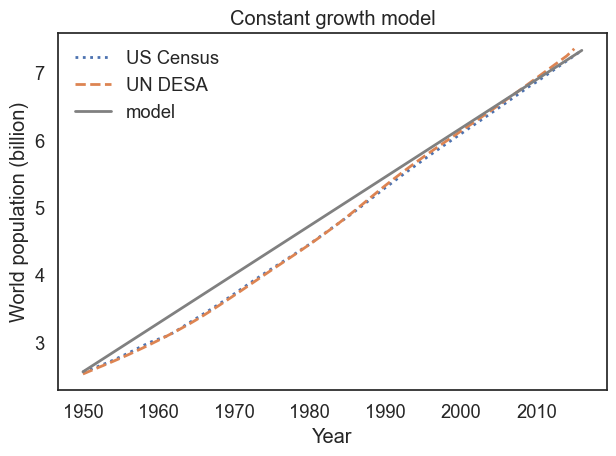

In [10]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [11]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [12]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

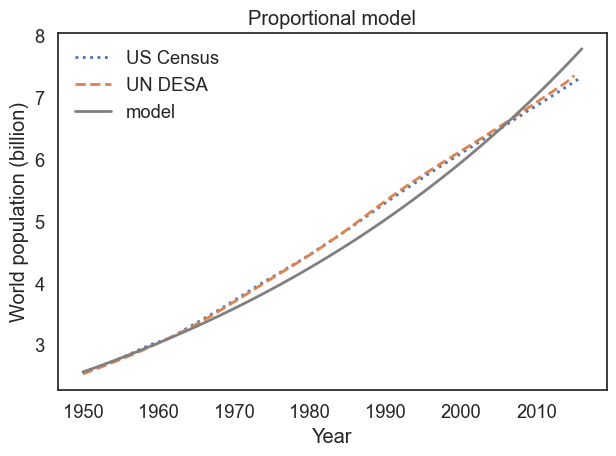

In [18]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
#savefig('figs/chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [19]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [20]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [21]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [22]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [23]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


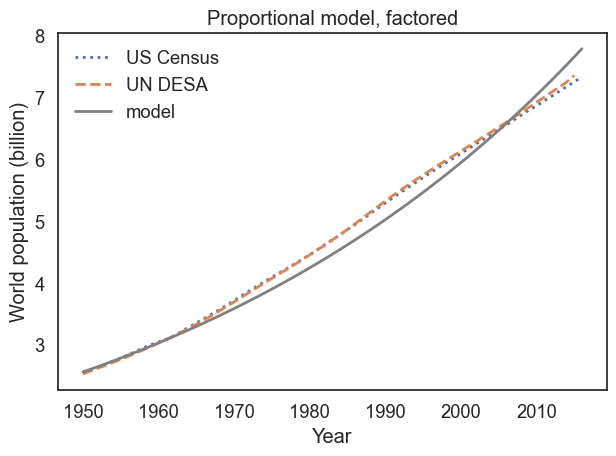

In [24]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

In [29]:
def update_func_exercise(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    print(t, pop)
    return pop + births - deaths

run_simulation(system, update_func_exercise);

1950 2.557628654
1951 2.601108341118
1952 2.645327182917006
1953 2.6902977450265952
1954 2.7360328066920476
1955 2.7825453644058125
1956 2.829848635600711
1957 2.8779560624059233
1958 2.926881315466824
1959 2.9766382978297603
1960 3.0272411488928666
1961 3.078704248424045
1962 3.131042220647254
1963 3.184269938398258
1964 3.2384025273510284
1965 3.293455370315996
1966 3.349444111611368
1967 3.406384661508761
1968 3.46429320075441
1969 3.523186185167235
1970 3.583080350315078
1971 3.6439927162704344
1972 3.7059405924470314
1973 3.768941582518631
1974 3.833013589421448
1975 3.8981748204416125
1976 3.9644437923891203
1977 4.031839336859735
1978 4.100380605586351
1979 4.170087075881319
1980 4.240978556171301
1981 4.313075191626214
1982 4.3863974698838595
1983 4.460966226871885
1984 4.536802652728707
1985 4.613928297825096
1986 4.692365078888122
1987 4.77213528522922
1988 4.8532615850781164
1989 4.935767032024445
1990 5.0196750715688605
1991 5.1050095477855315
1992 5.191794710097886
1993 5.

We see from the above printout that the `run_simulation` function produces a population estimate for every year between 1950 and 2015. As expected, the population increases over this time. 

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [31]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop
    return pop + net_growth

Here's how it works:

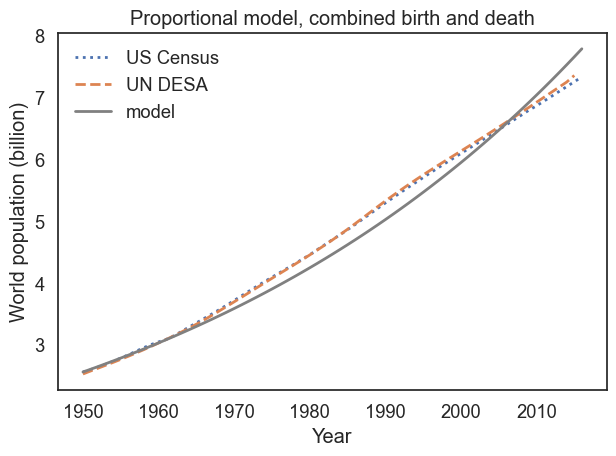

In [32]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [35]:
system.alpha1 = 0.0189 #Growth rate upto 1980
system.alpha2 = 0.0147 #Growth rate after 1980

def update_func_exercise(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1980:
        alpha = system.alpha1
    else: 
        alpha = system.alpha2
    net_growth = alpha * pop
    return pop + net_growth

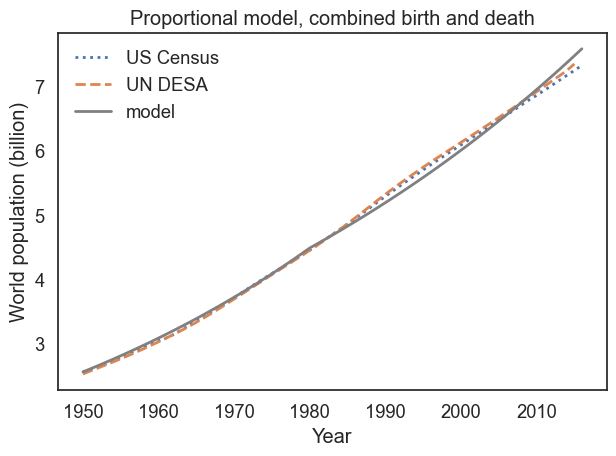

In [37]:
# Solution goes here

results = run_simulation(system, update_func_exercise)
plot_results(census, un, results, 'Proportional model, combined birth and death')

We can see that by using better birth rates, our data is a much better fit to the function. 

# Part 2

Complete the exercises found [here](https://github.com/AllenDowney/ModSimPy/blob/master/notebooks/chap07.ipynb).


### Code from the previous chapter

In [38]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [39]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [40]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [41]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [42]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

### Quadratic growth

Here's the implementation of the quadratic growth model.

In [43]:
def update_func_quad(pop, t, system):
    """Compute the population next year with a quadratic model.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

Here's a `System` object with the parameters `alpha` and `beta`:

In [65]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
alpha,0.025000
beta,-0.001800


And here are the results.

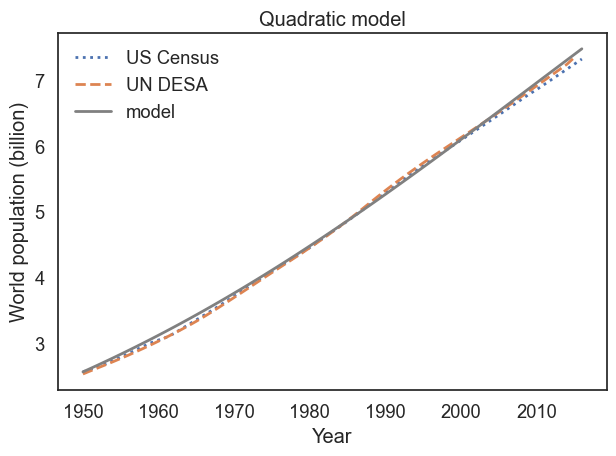

In [45]:
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')
#savefig('figs/chap07-fig01.pdf')

**Exercise:**  Can you find values for the parameters that make the model fit better?

In [67]:
from scipy.optimize import curve_fit

def quad_func(x, a, b):
    return a * x + b * x ** 2 

popt, pcov = curve_fit(quad_func, census.index - census.index[0], census.values)

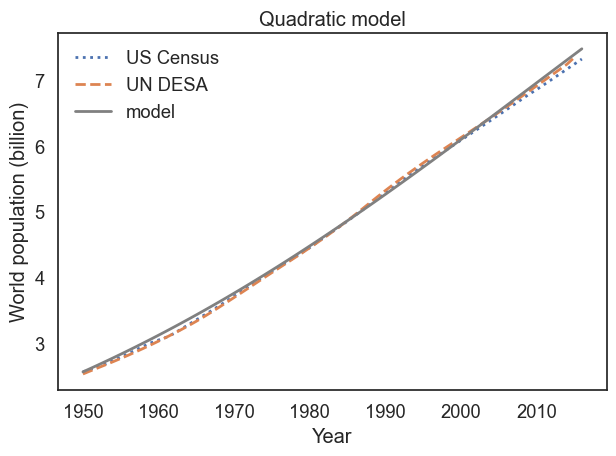

In [68]:
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')

### Equilibrium

To understand the quadratic model better, let's plot net growth as a function of population.

In [10]:
pop_array = linspace(0, 15, 100)
net_growth_array = system.alpha * pop_array + system.beta * pop_array**2
None

Here's what it looks like.

In [11]:
sns.set_style('whitegrid')

plot(pop_array, net_growth_array)
decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)')

sns.set_style('white')

savefig('figs/chap07-fig02.pdf')

Here's what it looks like.  Remember that the x axis is population now, not time.

It looks like the growth rate passes through 0 when the population is a little less than 14 billion.

In the book we found that the net growth is 0 when the population is $-\alpha/\beta$:

In [12]:
-system.alpha / system.beta

This is the equilibrium the population tends toward.

`sns` is a library called Seaborn which provides functions that control the appearance of plots.  In this case I want a grid to make it easier to estimate the population where the growth rate crosses through 0.

### Dysfunctions

When people first learn about functions, there are a few things they often find confusing.  In this section I present and explain some common problems with functions.

As an example, suppose you want a function that takes a `System` object, with variables `alpha` and `beta`, as a parameter and computes the carrying capacity, `-alpha/beta`.  Here's a good solution:

In [13]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

Now let's see all the ways that can go wrong.

**Dysfunction #1:** Not using parameters.  In the following version, the function doesn't take any parameters; when `sys1` appears inside the function, it refers to the object we created outside the function.


In [14]:
def carrying_capacity():
    K = -sys1.alpha / sys1.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity()
print(pop)

This version actually works, but it is not as versatile as it could be.  If there are several `System` objects, this function can only work with one of them, and only if it is named `system`.

**Dysfunction #2:** Clobbering the parameters.  When people first learn about parameters, they often write functions like this:

In [15]:
def carrying_capacity(system):
    system = System(alpha=0.025, beta=-0.0018)
    K = -system.alpha / system.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

In this example, we have a `System` object named `sys1` that gets passed as an argument to `carrying_capacity`.  But when the function runs, it ignores the argument and immediately replaces it with a new `System` object.  As a result, this function always returns the same value, no matter what argument is passed.

When you write a function, you generally don't know what the values of the parameters will be.  Your job is to write a function that works for any valid values.  If you assign your own values to the parameters, you defeat the whole purpose of functions.


**Dysfunction #3:** No return value.  Here's a version that computes the value of `K` but doesn't return it.

In [16]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

A function that doesn't have a return statement always returns a special value called `None`, so in this example the value of `pop` is `None`.  If you are debugging a program and find that the value of a variable is `None` when it shouldn't be, a function without a return statement is a likely cause.

**Dysfunction #4:** Ignoring the return value.  Finally, here's a version where the function is correct, but the way it's used is not.

In [17]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K
    
sys2 = System(alpha=0.025, beta=-0.0018)
carrying_capacity(sys2)

# print(K)     This line won't work because K only exists inside the function.

In this example, `carrying_capacity` runs and returns `K`, but the return value is dropped.

When you call a function that returns a value, you should do something with the result.  Often you assign it to a variable, as in the previous examples, but you can also use it as part of an expression.

For example, you could eliminate the temporary variable `pop` like this:

In [18]:
print(carrying_capacity(sys1))

Or if you had more than one system, you could compute the total carrying capacity like this:


In [19]:
total = carrying_capacity(sys1) + carrying_capacity(sys2)
total

## Exercises

**Exercise:** In the book, I present a different way to parameterize the quadratic model:

$ \Delta p = r p (1 - p / K) $

where $r=\alpha$ and $K=-\alpha/\beta$.  Write a version of `update_func` that implements this version of the model.  Test it by computing the values of `r` and `K` that correspond to `alpha=0.025, beta=-0.0018`, and confirm that you get the same results. 

In [69]:
def update_func_quad(pop, t, system):
    """Compute the population next year with a quadratic model.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    K = -system.alpha / system.beta
    
    net_growth = system.alpha * pop * (1 - pop / K)
    return pop + net_growth

In [21]:
# Solution goes here

In [22]:
# Solution goes here